In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from utils import display

2024-10-04 16:22:19.018391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 16:22:22.044341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [3]:
## Load the data downloaded from Tensorflow

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

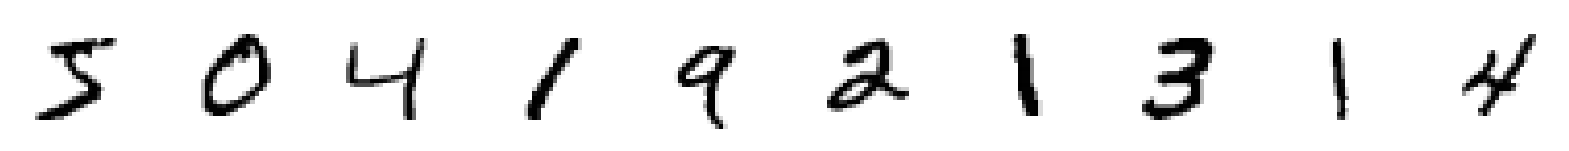

In [5]:

display(x_train)

## 2. Build the variational autoencoder <a name="build"></a>

In [6]:
# Sampling class
class Sampling(layers.Layer):
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
# Encoder

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='encoder_input')
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)

z_mean = layers.Dense(EMBEDDING_DIM, name='z_mean')(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

2024-10-04 16:22:31.452158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 16:22:31.845955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 16:22:31.850111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# The Variational Autoencoder

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]
    
    def call(self, inputs):
        ''' Call the model on a particular input '''
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        ''' Step run during training '''
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, 
                                                                                   axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - 
                                                          tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss
    
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        ''' Step run during validation '''
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, 
                                                                                   axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - 
                                                          tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss
        
        return {'loss': total_loss, 'reconstruction_loss': reconstruction_loss,
                'kl_loss': kl_loss}
        
        

In [10]:
# Create a variational autoencoder

vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [11]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [12]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [13]:
with tf.device('/GPU:0'):
    vae.fit(
        x_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[model_checkpoint_callback, tensorboard_callback],
    )

2024-10-04 16:22:36.755936: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-04 16:22:38.421805: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1728076962.271872   32287 service.cc:145] XLA service 0x61df49128a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728076962.273181   32287 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-04 16:22:42.455036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 16:22:43.055836: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1728076975.454560   32287 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 2.8927 - reconstruction_loss: 136.4695 - total_loss: 139.3621

2024-10-04 16:23:01.012300: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-10-04 16:23:01.230352: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-10-04 16:23:01.339999: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - kl_loss: 2.8931 - reconstruction_loss: 136.3489 - total_loss: 139.2420 - val_kl_loss: 3.7776 - val_loss: 84.4842 - val_reconstruction_loss: 80.7066
Epoch 2/10


/home/dsu/genai/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - kl_loss: 3.7717 - reconstruction_loss: 80.0497 - total_loss: 83.8214 - val_kl_loss: 4.2693 - val_loss: 79.9948 - val_reconstruction_loss: 75.7255
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 4.2288 - reconstruction_loss: 76.7312 - total_loss: 80.9600 - val_kl_loss: 4.3575 - val_loss: 78.4403 - val_reconstruction_loss: 74.0828
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 4.4840 - reconstruction_loss: 75.0707 - total_loss: 79.5548 - val_kl_loss: 4.6443 - val_loss: 77.7120 - val_reconstruction_loss: 73.0677
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - kl_loss: 4.6646 - reconstruction_loss: 73.8618 - total_loss: 78.5264 - val_kl_loss: 4.8759 - val_loss: 76.7959 - val_reconstruction_loss: 71.9200
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 4.7914 - reconstruction_loss: 72.9868 - total_loss: 77.7782 - val_kl_loss: 4.9626 - val_loss: 77.2301 - val_reconstruction_loss: 72.2675
Epoch 7

In [14]:
# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder_vae.keras")
decoder.save("./models/decoder_vae.keras")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [15]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
Example real clothing items


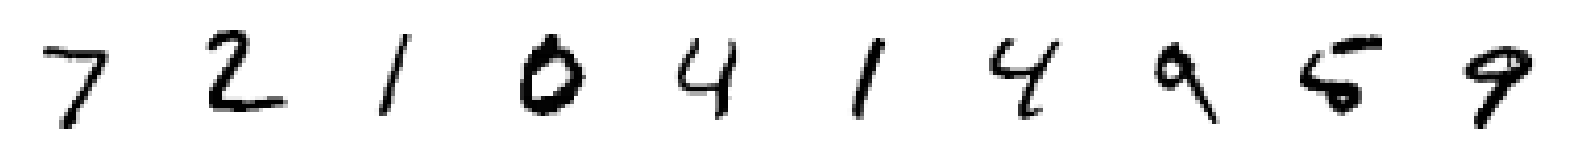

Reconstructions


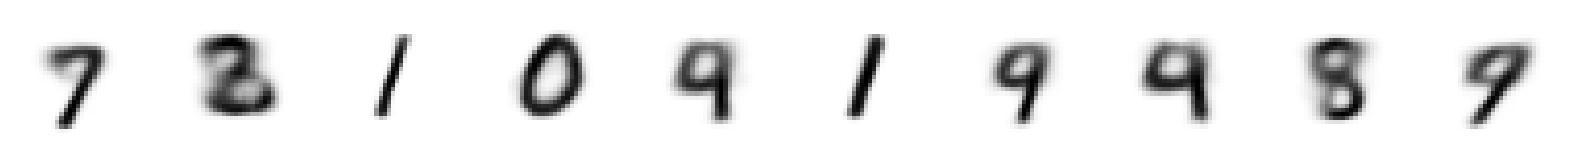

In [16]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Embed using the encoder <a name="encode"></a>

In [17]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [18]:
# Some examples of the embeddings
print(z[:10])

[[-0.07759707 -0.9408307 ]
 [-0.5772939   0.5784246 ]
 [ 1.4808675  -2.250722  ]
 [ 1.1170568   1.4114399 ]
 [-1.3682432  -0.13688357]
 [ 1.327096   -1.421027  ]
 [-0.97048384 -0.64320165]
 [-1.9211627   0.16913784]
 [-0.5644162   0.06894058]
 [ 0.20387574 -0.6848797 ]]


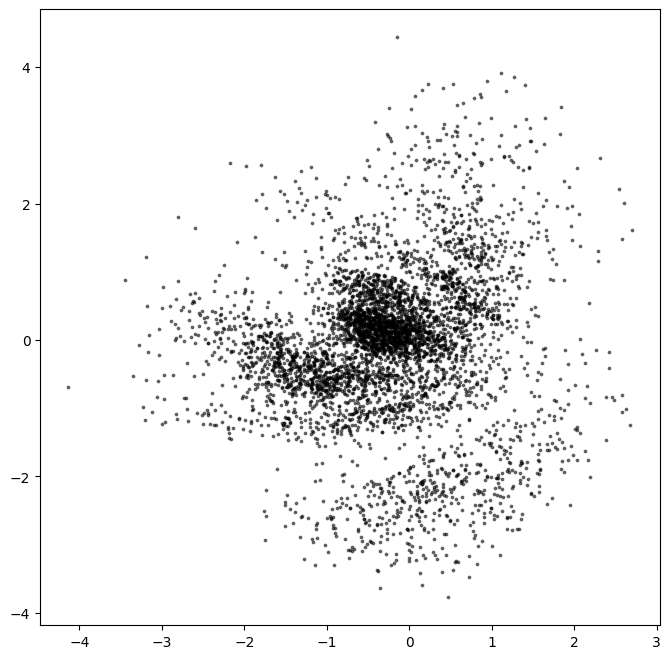

In [19]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [20]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [21]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


In [22]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

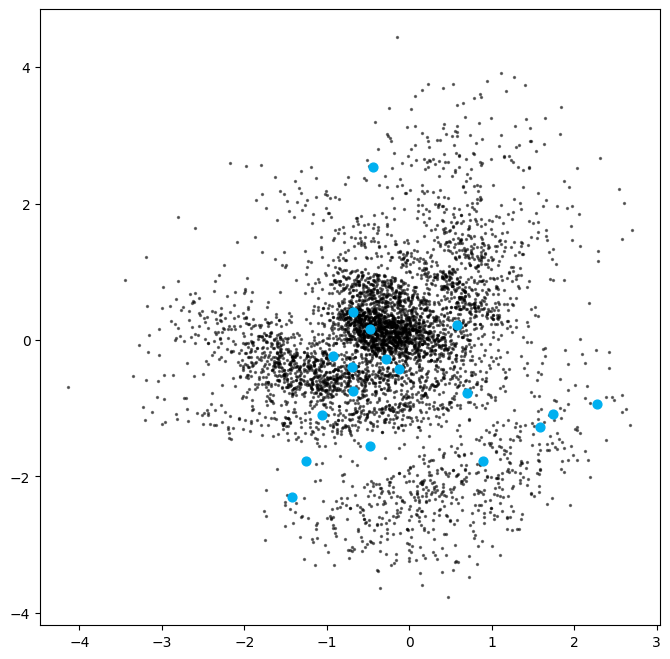

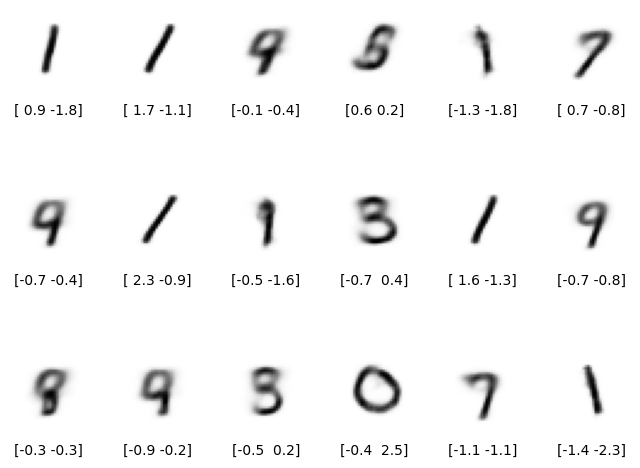

In [23]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

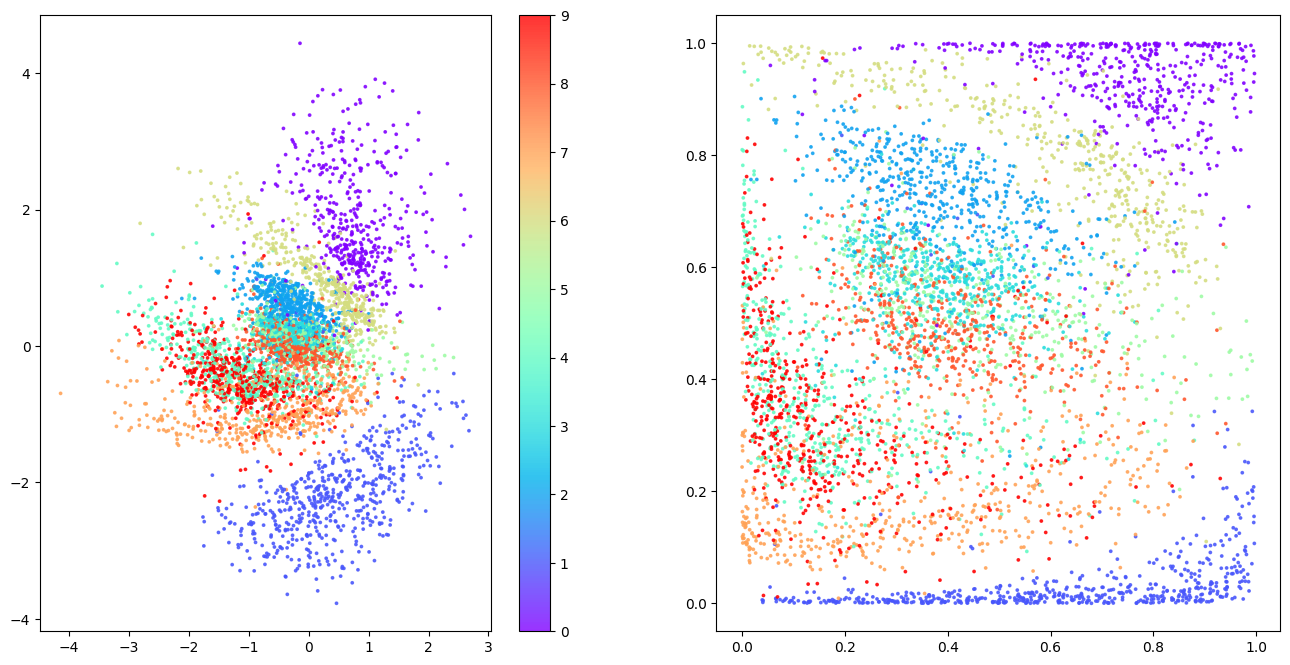

In [24]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


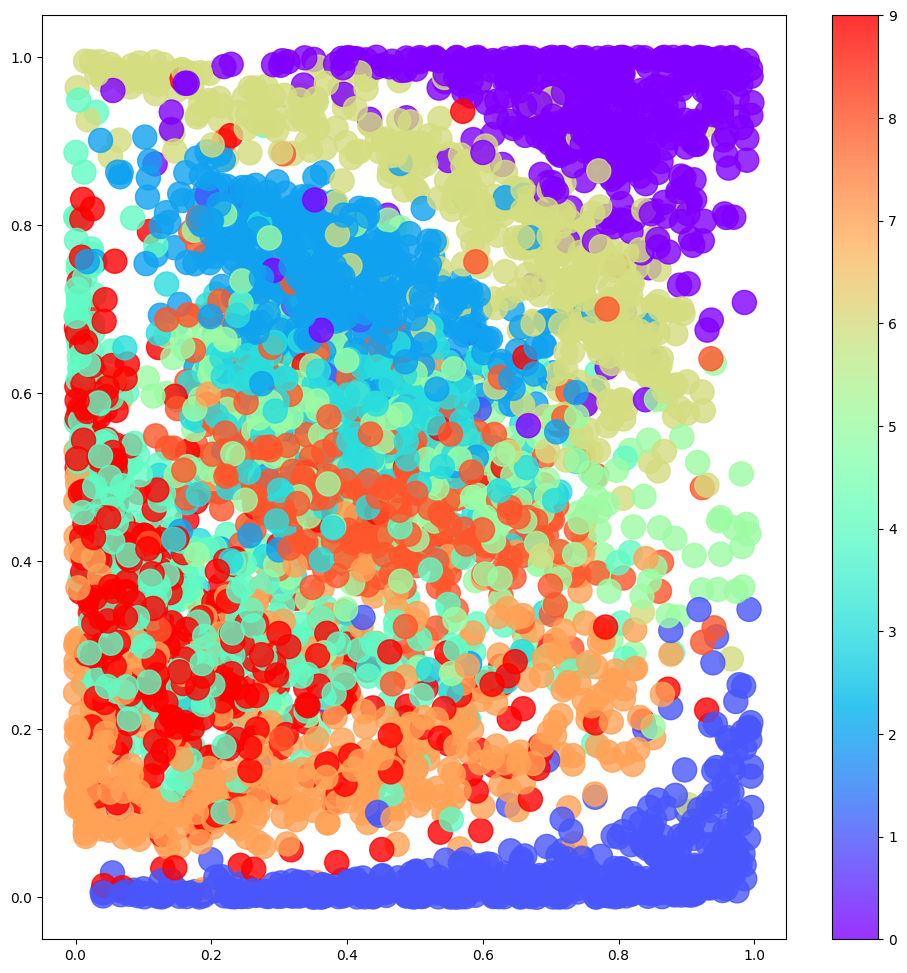

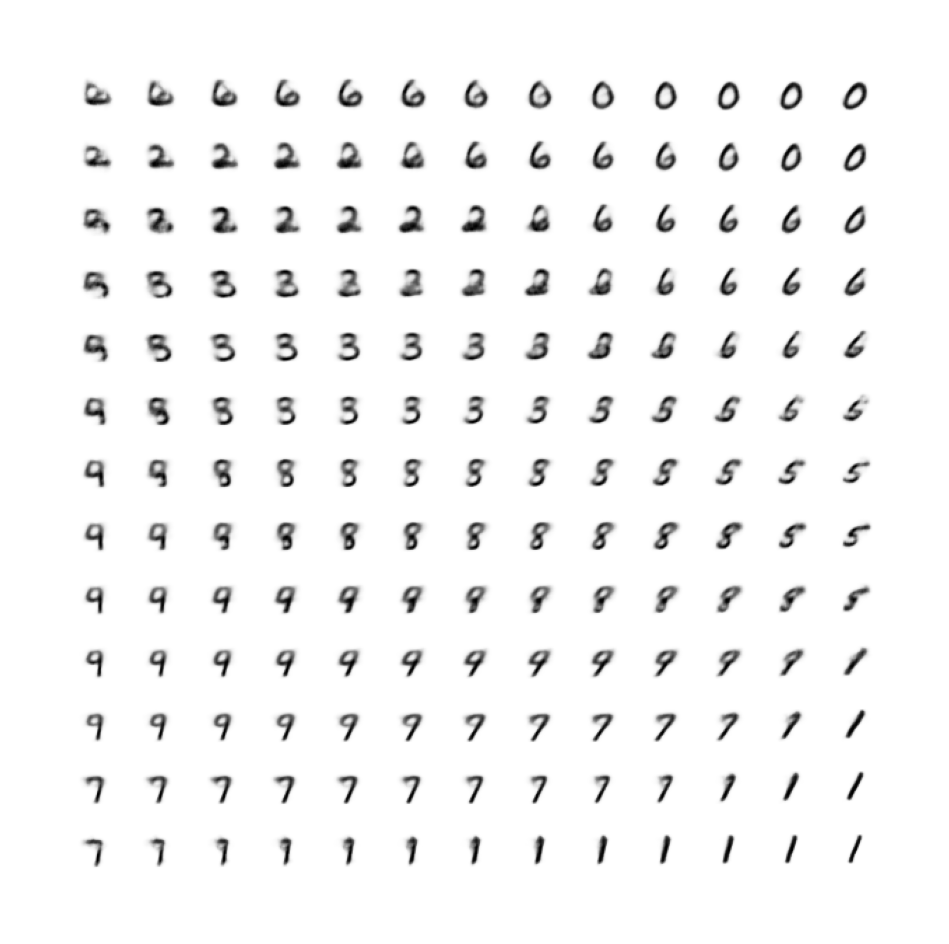

In [25]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")